# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [104]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
# created color class in order to add bold, colors to printed text
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
#print(color.BOLD + 'example text' + color.END)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [105]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=";")# optional: error_bad_lines=False) 

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=";")# optional: error_bad_lines=False)

In [106]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()
# as trying to import it as it is, the data gave an error. Then I added the "error_bad_lines=False" clause and realized that
#the data was separated by ";" and not by ",". 

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [107]:
print (f'it has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
print ('***********************')
print (f'and it has the following NaN values {azdias.isna().sum().sum()}')

it has 891221 rows and 85 columns
***********************
and it has the following NaN values 4896838


In [108]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [109]:
feat_info # this will give us the type of data comprised in each category

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [110]:
# Identify missing or unknown data values and convert them to NaNs.

# I've got stuck at this point and went to the mentor help knowledge base. So this solution is according to what's written there.
#credits go to mentors MISGANA BAYETTA B and Rajat S

def string_to_list_value(x):
    na_list=[]
    x = x[1:-1].split(',')
    for i in x:
            try:
                na_list.append(int(i))
            except:
                na_list.append(i)
    return na_list

feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_to_list_value)

In [111]:
feat_info['NA_tags']

0        [-1, 0]
1     [-1, 0, 9]
2        [-1, 0]
3            [0]
4           [-1]
5           [-1]
6           [-1]
7           [-1]
8           [-1]
9           [-1]
10          [-1]
11           [0]
12            []
13            []
14       [-1, 0]
15           [0]
16           [0]
17           [0]
18           [0]
19           [0]
20           [0]
21       [-1, 0]
22       [-1, 0]
23           [0]
24       [-1, 9]
25       [-1, 9]
26       [-1, 9]
27       [-1, 9]
28       [-1, 9]
29       [-1, 9]
         ...    
55          [-1]
56          [-1]
57       [-1, X]
58          [XX]
59      [-1, XX]
60          [-1]
61          [-1]
62          [-1]
63          [-1]
64       [-1, 0]
65       [-1, 0]
66          [-1]
67          [-1]
68          [-1]
69            []
70       [-1, 0]
71            []
72            []
73       [-1, 0]
74            []
75          [-1]
76          [-1]
77          [-1]
78          [-1]
79       [-1, 0]
80          [-1]
81          [-1]
82       [-1, 

In [112]:
# I've got stuck at this point and went to the mentor help knowledge base. So this solution is according to what's written there.
#credits go to mentor MISGANA BAYETTA B

att_index = feat_info.set_index('attribute') #copy of the feat_info
na_azdias = azdias[:] # create a copy of the data to replace the nans

#Below we can look through each column, using the att_index DataFrame as a reference to encode our NA values.
#We needed the features to be the index of the dataframe in order to use .loc to retrieve each column's respective 
#list of NA codes. So, we Loop through our column names:

for column in na_azdias.columns: #go through each column and compare to feat_info index. If value is the same, we'll get a NaN.
    na_azdias[column].replace(to_replace=att_index.loc[column].loc['NA_tags'],value=np.NaN,inplace=True)
   
print (color.BOLD + f'final number of NaNs = {na_azdias.isna().sum().sum()}' + color.END)                   
 #this should give the final total of NaNs.


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


final number of NaNs = 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

<function matplotlib.pyplot.show(*args, **kw)>

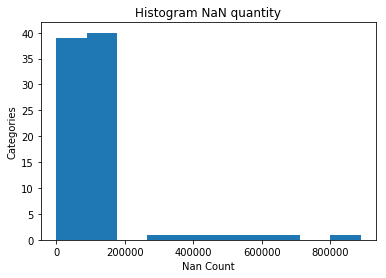

In [113]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
na_azdias.isnull().sum().sort_values(ascending=False)

fig, ax = plt.subplots(1, 1)
ax.hist(na_azdias.isnull().sum())

ax.set_title("Histogram NaN quantity")
ax.set_xlabel('Nan Count')
ax.set_ylabel('Categories')
plt.show

In [114]:
# Investigate patterns in the amount of missing data in each column.

missing_for_plotting = pd.Series(na_azdias.isna().sum()) #create a series with the sum of the nans for each category

missing_for_plotting = missing_for_plotting/len(na_azdias)*100 # divide by total quantity in order to get percentage
missing_for_plotting.sort_values(ascending=True, inplace=True) # order the data in ascending form

In [115]:
plot_index = missing_for_plotting[missing_for_plotting == 0].index #creating index with categorys with zero Nans to remove form plot
plot_na = missing_for_plotting.drop(plot_index) #removing categories with 0 Nans. 

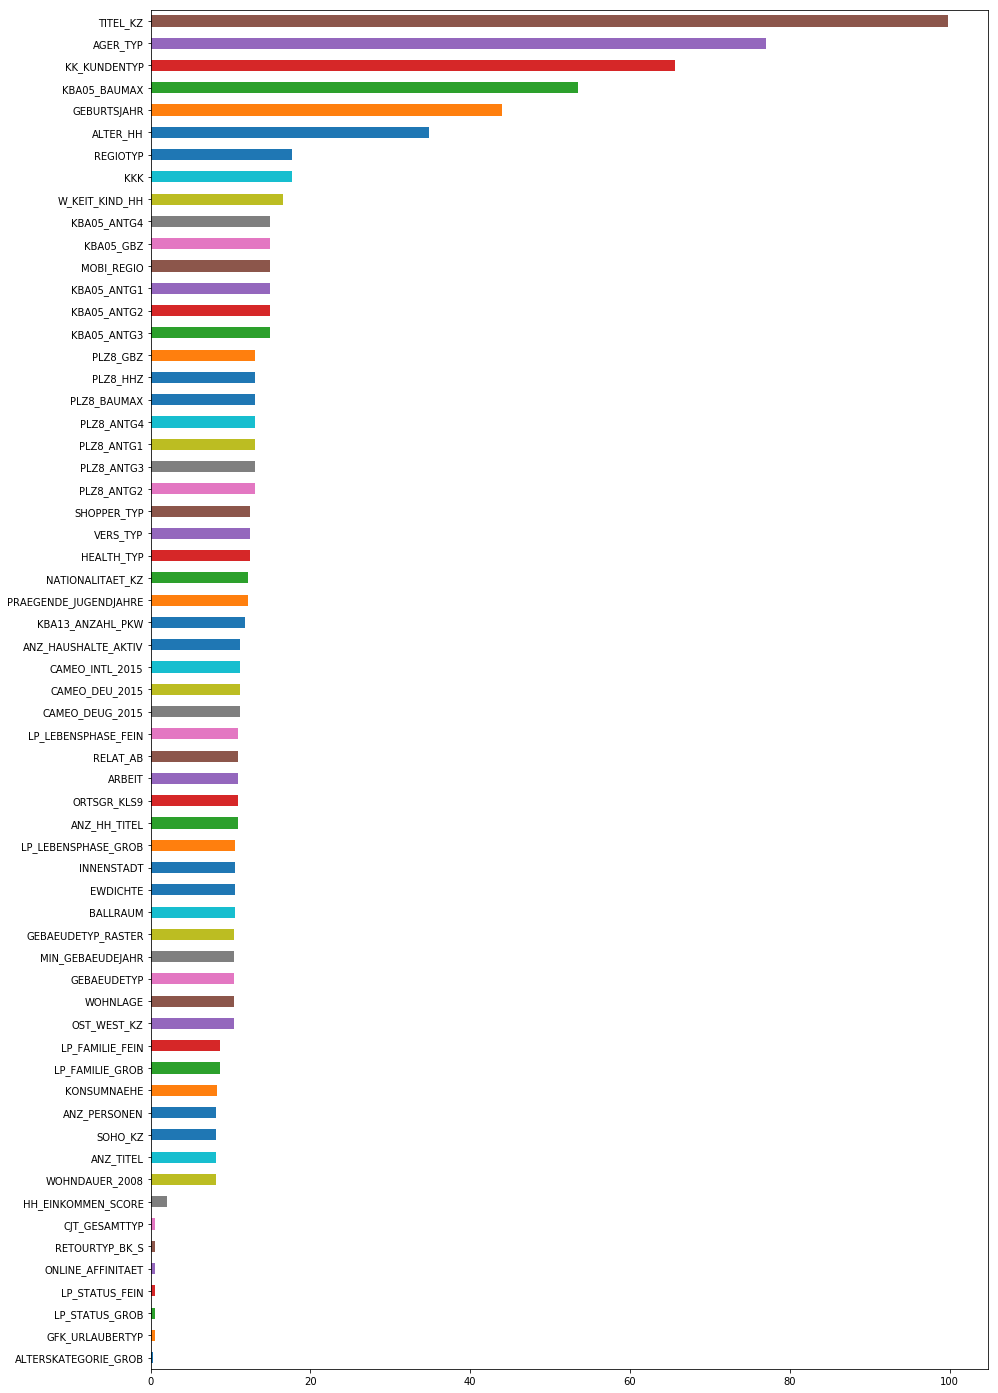

In [116]:
plot_na.plot(x="percentage", y="Category",kind="barh", figsize = (15,25))

In [117]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop = list(na_azdias.isnull().sum()[na_azdias.isnull().sum()>200000].index)

print (color.BOLD + f' The following columns are deeemed outliers as the have more NaNs as other categories {drop}'+ color.END)


 The following columns are deeemed outliers as the have more NaNs as other categories ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [118]:
new_azdias= na_azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],axis=1)
#dropped the above mentioned columns

In [119]:
new_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I did first a histogram to see if the Nan "distribution" was even accross the board, or there were some columns with more Nan than others. It results that some columns do have a lot more of NaN value thatn others. I then proceeded to do a bar chart in percentage of the total of rows, to identify which categories were creating so much noise. I deemed as correct to drop the colunmns that have more than 30% of NaNS. These include following columns: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

there are several columns with more or less the same amount of NaNs. Could be that some information across the row is missing, impacting at the same time at all these columns. Further investigation is necessary.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

 We have a total of 5035304 of Nans, with some rows having more than 10 missing values per row.


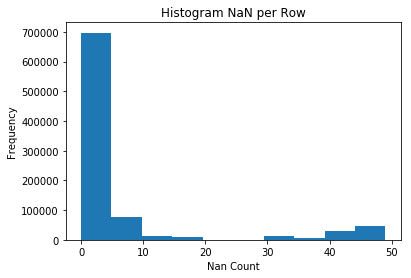

In [120]:
# How much data is missing in each row of the dataset?
missing_rows = new_azdias.isnull().sum(axis = 1)

fig, ax = plt.subplots(1, 1)
ax.hist(missing_rows)

ax.set_title("Histogram NaN per Row")
ax.set_xlabel('Nan Count')
ax.set_ylabel('Frequency')
plt.show

print (f' We have a total of {missing_rows.sum()} of Nans, with some rows having more than 10 missing values per row.')

In [121]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_per_row_10 = new_azdias[new_azdias.isnull().sum(axis=1) > 10]
missing_per_row_less_10 = new_azdias[new_azdias.isnull().sum(axis=1) <= 10]

print (f' Subset with high count has {missing_per_row_10.isnull().sum().sum()} of Nans')
print (f' Subset with low count has {missing_per_row_less_10.isnull().sum().sum()} of Nans')


 Subset with high count has 4290986 of Nans
 Subset with low count has 744318 of Nans


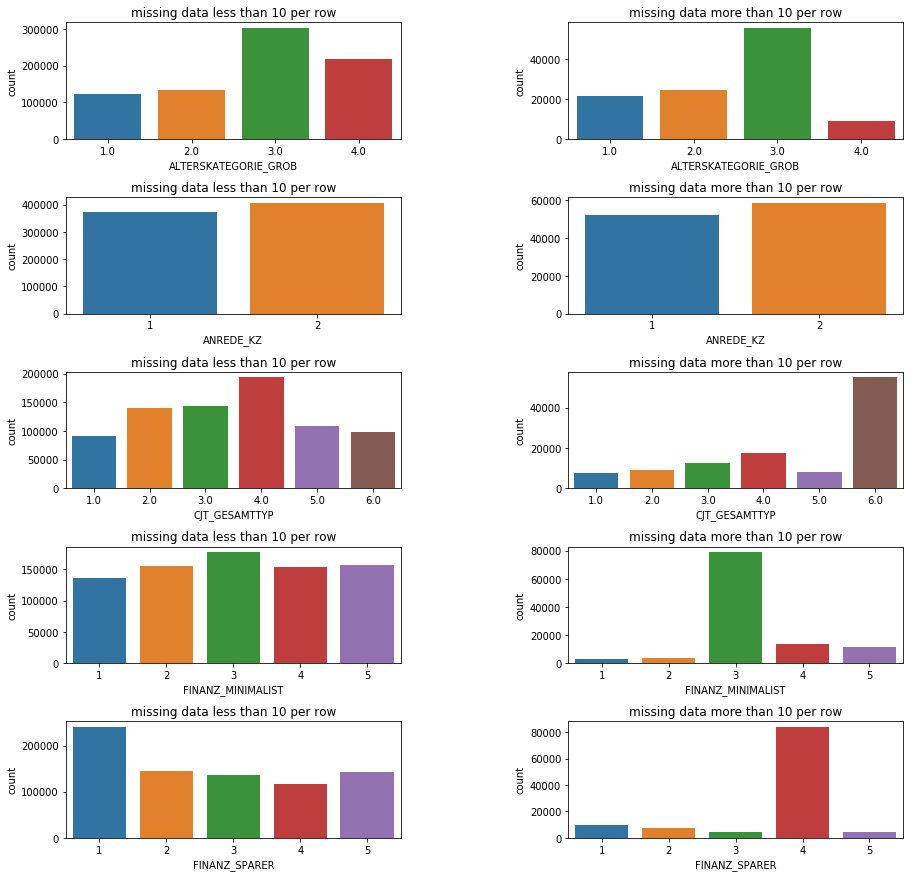

In [122]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot(columns, qty):
    fig, axs = plt.subplots(qty, 2, figsize=(15, 15))
    fig.subplots_adjust(hspace = 0.5 , wspace=.5)
    axs = axs.ravel()
    
    for i in range(qty):
        
        sns.countplot(missing_per_row_less_10[columns[i]], ax=axs[i*2])
        axs[i*2].set_title('missing data less than 10 per row')
        sns.countplot(missing_per_row_10[columns[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('missing data more than 10 per row')
        

idx= missing_per_row_10.columns
plot(idx, 5)



#### Discussion 1.1.3: Assess Missing Data in Each Row

Doing a histogram like when analyzing the columns, it also comes into view that there are some rows with a lot of missing values. As having 79 columns, I decided to divide the data into two subsets: one subset with less than 10 missing points and the other with more than 10 missing points per row. I decided on 10, as the histogram shows that most of the rows have less than 10 missing values per row, and when it is higher that that, it seems to be "outlier" data. Since the values are discrete, the data distribution looks for like a histogram.

Comparing the data distribution betwwen the two subsets, in some cases the data has the same distribution, but in other it doesn´t. For example the first two compared columns (ALTERSKATEGORIE_GROB and ANREDE_KZ) seems to have same distribution. For the other 3, it peaks in different values (6 vs 4, 3 vs 3 but with different distribution and 4 vs 1)', and the distribution is quite not the same. It may be that this data set comes from another source as the other data, hence missing some values. I would continue the analysis with the data subset with few NaNs ( 744318 vs 4290986!!!). The other subset can be used later in the analysis to compare, as if the data comes from another source, it could be worth to analyze it alone. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [123]:
# How many features are there of each data type?

feat_info_rem = feat_info[feat_info.attribute.isin(missing_per_row_less_10.columns)] # removing the dropped columns in a copy of feat info
print(feat_info_rem.groupby('type').count())

             attribute  information_level  missing_or_unknown  NA_tags
type                                                                  
categorical         18                 18                  18       18
mixed                6                  6                   6        6
numeric              6                  6                   6        6
ordinal             49                 49                  49       49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [124]:
# I define the categorical features from the feat_info file

cat_features = feat_info_rem[feat_info_rem["type"]=="categorical"]["attribute"]
cat_features = list(cat_features)

print (cat_features)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [125]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

multi =[]
binary = []

for feature in cat_features:
    if len(missing_per_row_less_10[feature].unique()) == 2:
        binary.append(feature)
binary.append('VERS_TYP')# added later, as it is binary, but with this method and having nans, it will go to multilevel 
multi = [x for x in cat_features if x not in binary]

print (f' the following are multi-level variables {multi}')
for feature in multi:
    print(f'The feature {feature} has following unique values: {missing_per_row_less_10[feature].unique()}')
print (color.BOLD+'------------------------------------------'+color.END)
print (f' the following are binary variables {binary}')
for feature in binary:
    print(f'The feature {feature} has following unique values: {missing_per_row_less_10[feature].unique()}')

 the following are multi-level variables ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
The feature CJT_GESAMTTYP has following unique values: [  5.   3.   2.   4.   1.   6.  nan]
The feature FINANZTYP has following unique values: [1 6 5 2 4 3]
The feature GFK_URLAUBERTYP has following unique values: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
The feature LP_FAMILIE_FEIN has following unique values: [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
The feature LP_FAMILIE_GROB has following unique values: [  3.   1.  nan   5.   2.   4.]
The feature LP_STATUS_FEIN has following unique values: [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
The feature LP_STATUS_GROB has following unique values: [  1.   2.   4.   5.   3.  nan]
The feature NATIONALITAET_KZ has following uni

In [126]:
# Re-encode categorical variable(s) to be kept in the analysis.
# first reenconde the binaries that have no binary values
missing_per_row_less_10['OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
missing_per_row_less_10['ANREDE_KZ'].replace({2:1, 1:0}, inplace=True)
missing_per_row_less_10['SOHO_KZ'].replace({1.:1, 0.:0}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [127]:
data_cat = missing_per_row_less_10.copy()

for category in multi:
        data_cat.drop(category, axis=1, inplace=True)

data_cat.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

I first identified which categories had "categorical" attributes, then proceeded to identify them as binary or multi level. One of the binary categories had "W" and "O" as values, and I changed them to 0 and 1 respectevely. I also corrected the values in the other categories for them to be 0 or 1s. 
For the multilevel categories, some are roughly the same like like LP_STATUS_FEIN and LP_STATUS_GROB, which refer to social status and are redundant. The same happens with LP_FAMILY. These cases will not give me much information and can be dropped. The other categories have a lot of levels and that might dilute the variability captured by components in the PCA step. So to avoid affecting the model via redundant information or dilution, I´ve dropped those columns. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [128]:
print (feat_info_rem[feat_info["type"]=="mixed"]["attribute"])

mixed_features = feat_info_rem[feat_info_rem["type"]=="mixed"]["attribute"]
mixed_features = list(mixed_features) # for use later to drop the columns already engineered




15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [129]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(sorted(data_cat['PRAEGENDE_JUGENDJAHRE'].unique()))
print('                                              ')
print('According to the data dictionary, one could make a '+color.RED+' decade variable'+color.END +', for example, 1 and 2 belong to'+color.PURPLE+ ' 40s'+color.END+', 3 and 4 to '+color.CYAN+' 50s'+color.END)
print('We could also create a new variable considering if they are '+color.RED+ 'mainstream '+ color.END + 'or '+color.BLUE+ 'avantgarde'+color.END)
# I create two dictionaries to reflect the data in the data dictionary. I'll one hot encode the values from 1. So, for example, 
# 40s is equal to 1, 50s, is equal to 2, and so on. 1
dict_decade = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
dict_movement = {1:1,3:1,5:1,8:1,10:1,12:1,14:1,2:2,4:2,6:2,7:2,9:2,11:2,13:2}
data_cat['PRAEG_DECADE'] = data_cat['PRAEGENDE_JUGENDJAHRE'].map(dict_decade)
data_cat['PRAEG_MOVEMENT'] = data_cat['PRAEGENDE_JUGENDJAHRE'].map(dict_movement)
      

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, nan]
                                              
According to the data dictionary, one could make a  decade variable, for example, 1 and 2 belong to 40s, 3 and 4 to  50s
We could also create a new variable considering if they are mainstream or avantgarde


I re-engineered "PRAEGENDE_JUGENDJAHRE" (Forming years) as the two following variables:

PRAEG_DECADE (forming decade):

Person’s decade in which they were young:

    1: 40s     2: 50s     3: 60s     4: 70s     5: 80s     6: 90s

PRAEG_MOVEMENT (forming movement):

Person’s movement when they where young

    1: Mainstream     2: Avantgarde


# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [130]:
a = data_cat['CAMEO_INTL_2015'].unique()
print (f'It has the following values {a}')


It has the following values ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']


### Two new variables 

we can create two new variables, the first one, "wealth", could be inferred from the first digit, and the second variable, "Life Stage" from the second digit.

CAMEO_WEALTH = Household's wealth

    1: Wealthy Households     2: Prosperous Households     3: Comfortable Households     4: Less Affluent Households
    5: Poorer Households

CAMEO_LIFE_STAGE = Person's Life Stage

    1: Pre-Family Couples & Singles     2: Young Couples With Children     3: Families With School Age Children
    4: Older Families & Mature Couples     5: Elders In Retirement


In [131]:
def extract_digit (x, position):
    try:
     
        if position == 1:
            return int(str(x)[0])
        elif  position == 2:
            return int(str(x)[1])
    except:
        x = np.nan
        
    return x
        

In [132]:
data_cat['CAMEO_WEALTH'] = data_cat['CAMEO_INTL_2015'].apply(extract_digit, position=1)
data_cat['CAMEO_LIFE_STAGE'] = data_cat['CAMEO_INTL_2015'].apply(extract_digit, position=2)

In [133]:
# Check if formula went well in one variable
data_cat['CAMEO_WEALTH'].isnull().sum() == data_cat['CAMEO_INTL_2015'].isnull().sum()

True

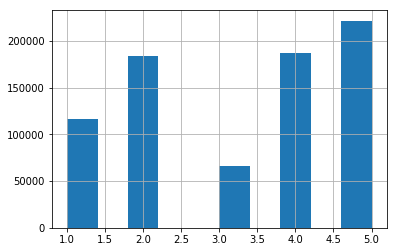

In [134]:
data_cat['CAMEO_WEALTH'].hist()

#### Now I proceed to drop the mixed columns, as I reengineered two of them. 

In [135]:
data_clean = data_cat.copy()

for category in mixed_features:
        data_clean.drop(category, axis=1, inplace=True)

data_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEG_DECADE,PRAEG_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,NaN,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 6 mixed variables remaining in the dataset: 
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
PLZ8_BAUMAX

From these variables, I analyzed "PRAEGENDE_JUGENDJAHRE" and decided to create two variables from it. One information that we got was in which decade they spent their youth and the other which kind of movement they followed. So PRAEG_DECADE and PRAEG_MOVEMENT were created. At the end I dropped the column with the original data. 

I also analyzed CAMEO_INTL_2015 which has two information on it: Wealth and life stage. As the data is enconded in two digit numbers, the first representing the wealth, and the second representing the life stage, I created two variables with this information. At the end I droppped the column with the original data. 

I chose to drop the remaining mixed features to keep things simple for now. They can be revisited later. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [136]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [137]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [138]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df_clean = df.copy()
    features = feat_info.copy()
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    def string_to_list_value(x):
        na_list=[]
        x = x[1:-1].split(',')
        for i in x:
                try:
                    na_list.append(int(i))
                except:
                    na_list.append(i)
        return na_list

    features['NA_tags'] = features['missing_or_unknown'].apply(string_to_list_value)
    features = features.set_index('attribute')
    for column in df_clean.columns:
        df_clean[column].replace(to_replace=features.loc[column].loc['NA_tags'],value=np.NaN,inplace=True)
    
    
    # remove selected columns and rows, ...
    
    df_clean= df_clean.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],axis=1)
    #making subset of rows with more than 10 missing NAn per Row
    df_clean_high = df_clean[df_clean.isnull().sum(axis=1) > 10]
    # keeping rows with less than 10 nans
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 10]
    
    
    
    # listing remaining features and defining categorical ones
    features = feat_info[feat_info.attribute.isin(df_clean.columns)]
    cat_features = features[features["type"]=="categorical"]["attribute"]
    cat_features = list(cat_features)
       
    multi =[]
    binary = []
    # appending binaries and then getting multi
    for feature in cat_features:
        if len(df_clean[feature].unique()) == 2:
            binary.append(feature)
    binary.append('VERS_TYP')
    multi = [x for x in cat_features if x not in binary]
    
    #reencoding binaries
    df_clean['OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace=True)
    df_clean['ANREDE_KZ'].replace({2:1, 1:0}, inplace=True)
    df_clean['SOHO_KZ'].replace({1.:1, 0.:0}, inplace=True)
    
    for category in multi:
        df_clean.drop(category, axis=1, inplace=True)
    
   
    # select, re-encode, and engineer column values.
    # define the mix features 
    mixed_features = features[features["type"]=="mixed"]["attribute"]
    mixed_features = list(mixed_features)
    
    # enconde first engineered variable
    dict_decade = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    dict_movement = {1:1,3:1,5:1,8:1,10:1,12:1,14:1,2:2,4:2,6:2,7:2,9:2,11:2,13:2}
    df_clean['PRAEG_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(dict_decade)
    df_clean['PRAEG_MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(dict_movement)
       
    #define function for second engineered variable
    def extract_digit (x, position):
        try:
     
            if position == 1:
                return int(str(x)[0])
            elif  position == 2:
                return int(str(x)[1])
        except:
            x = np.nan
        
        return x
    # generate second engineered variable
    df_clean['CAMEO_WEALTH'] = df_clean['CAMEO_INTL_2015'].apply(extract_digit, position=1)
    df_clean['CAMEO_LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].apply(extract_digit, position=2)
    
    #drop the final columns
    
    for category in mixed_features:
        df_clean.drop(category, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_clean, df_clean_high
    

In [139]:
# copied the database just in case
azdias_test= azdias.copy()

In [140]:
#testing if it works... 
df_clean, df_clean_high= clean_data(azdias_test)

df_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEG_DECADE,PRAEG_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,NaN,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [141]:
df_clean_high.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
df_diff = pd.concat([data_clean,df_clean]).drop_duplicates(keep=False)

if df_diff.sum().sum() == 0:
    print (color.GREEN+color.BOLD+'The function works and both databases are equal!!!!! GREAT JOB'+color.END)
else:
    print(color.RED+color.BOLD+'oooooops, try again!!!'+color.END)

The function works and both databases are equal!!!!! GREAT JOB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [143]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print (f'We still have {data_clean.isnull().sum().sum()} NaN values in the data set' )
print ("I will proceed creating an imputer to change the NaN values to the most frequent one in the column")

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0,copy=False)
imp= imp.fit(data_clean)
data_trans = data_clean.copy()
data_trans[:] = imp.transform(data_clean)
print (color.BOLD+'Imputing, please wait................'+color.END)
print (f'now we have {data_trans.isnull().sum().sum()} NaNs, as they were replaced by the most frequent value in the column')

data_trans.head()



We still have 570123 NaN values in the data set
I will proceed creating an imputer to change the NaN values to the most frequent one in the column
Imputing, please wait................
now we have 0 NaNs, as they were replaced by the most frequent value in the column


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEG_DECADE,PRAEG_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFE_STAGE
1,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
3,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [144]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(data_trans)
data_trans[:] = scaler.transform(data_trans)
data_trans.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEG_DECADE,PRAEG_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFE_STAGE
1,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.006277,...,0.422909,1.435790,0.563767,-0.179002,-0.132852,0.679557,1.105284,-0.448526,1.170995,-1.249732
2,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.006277,...,-0.952555,0.405449,0.563767,-0.179002,-0.132852,-0.795517,1.105284,-0.448526,-0.874275,0.763856
3,1.180959,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.316158,...,-0.952555,-0.624893,0.563767,-1.182990,-1.003725,-0.057980,-0.259737,-0.448526,-1.556031,-0.578536
4,0.198089,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.006277,...,0.422909,-0.624893,-0.339941,0.824987,0.302585,1.417095,-0.259737,-0.448526,0.489238,0.092660
5,-1.767651,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.006277,...,0.422909,1.435790,1.467476,-1.182990,-1.003725,-0.057980,-1.624758,-0.448526,1.170995,0.763856


### Discussion 2.1: Apply Feature Scaling

I used the imputer to input the most frequent value in the column. I didn't drop the rows as it would imply losing a lot of data. Mean or median strategies are out of the question, as after applying the scaler, they will have a value of zero and that may reduce the variance of the data. 

For the Dataset with the inputed values, I applied the starndard scaler transformation.  


****************************************************************************************************************
I researched wether it was better to separate the database in two sets, one dropping the NaN rows and a copy of the original one, then doing the fitting with standardscaler in the dropped rows database, then imputing the the most_frequent in the original database and then transforming the data using the previous "clean" fit made with standardscaler. 

I found the following post in Mentor Help (can´t find it again for the url).

**QUOTE**

"Removing the missing values, scaling, and then imputing the values afterwords will produce the same result, but it's a lot more work in order to achieve the same result. Just impute the missing values first and then scale the data.

Traditionally, imputation is always performed before any scaling is done:

https://datascience.stackexchange.com/questions/53138/which-comes-first-multiple-imputation-splitting-into-train-test-or-standardiz
"

**END QUOTE**

So there is discussion in the forums regarding to wether its better to first imput and then scale, but there is no clear concensus. The only concensus is that it's faster to enconde the imputing first and scaling later. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [145]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca = pca.fit(data_trans)



In [146]:
# Investigate the variance accounted for by each principal component.

# define pca_results function like seen on class, removing the graphing part as it is too much information to visualize. 

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions


	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

pca_results(data_trans,pca)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEG_DECADE,PRAEG_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFE_STAGE
Dimension 1,0.1679,-0.1294,0.0060,-0.2238,0.1569,-0.1242,0.0784,0.0862,0.1582,-0.1091,...,0.2153,0.0415,-0.1647,0.1406,0.1943,0.1331,0.1169,-0.1167,0.2031,-0.1248
Dimension 2,0.1337,0.2534,0.0908,0.0573,-0.2286,0.2266,-0.2038,-0.2228,0.1221,-0.0132,...,0.1008,0.0161,-0.0805,0.0751,0.1035,0.0729,-0.2366,0.0392,0.0824,-0.0040
Dimension 3,0.0946,0.0763,-0.3685,0.1544,-0.1040,0.0986,-0.1886,-0.0981,-0.0435,0.0485,...,0.0482,0.0049,-0.0407,0.0366,0.0500,0.0335,-0.1087,0.0590,0.0290,-0.0104
Dimension 4,0.0511,-0.0586,0.0372,0.0701,-0.0021,-0.0186,-0.1267,0.0791,-0.1145,0.3884,...,0.0773,0.1448,0.0437,0.0495,0.2486,0.0935,0.0312,0.3516,-0.1304,0.0626
Dimension 5,0.0375,-0.0036,0.0100,0.0896,-0.0097,-0.0605,0.0364,-0.0526,-0.0910,0.0603,...,0.0234,-0.4834,-0.4017,0.2218,0.0940,0.1498,0.0173,0.0639,-0.0072,0.0229
Dimension 6,0.0318,0.0052,0.0138,-0.0132,0.0029,-0.0334,0.0161,-0.0158,-0.0024,0.0180,...,0.0904,-0.0099,-0.0678,-0.1700,-0.0597,-0.2054,0.0272,0.0109,-0.0755,0.0527
Dimension 7,0.0283,0.0458,-0.0542,0.0661,0.0448,-0.0105,0.0647,0.0489,-0.2036,-0.0209,...,0.0537,0.2365,0.1409,0.0302,0.1172,0.0432,0.0898,-0.0368,0.0177,-0.0804
Dimension 8,0.0251,0.1051,0.0292,-0.0211,0.0052,-0.0725,0.0577,-0.0279,0.0275,0.0249,...,0.0869,0.1135,0.0158,0.0645,-0.0881,-0.0034,0.0224,0.0143,0.0647,-0.0157
Dimension 9,0.0237,-0.0958,0.0908,0.1148,-0.1847,0.1424,-0.1212,-0.1623,-0.0038,-0.0199,...,-0.0046,0.1162,0.0948,0.1270,0.0792,0.0598,-0.1931,0.0507,-0.0149,0.0415
Dimension 10,0.0211,-0.0132,0.0133,0.0521,-0.0805,0.1808,-0.1404,-0.0098,-0.0995,-0.0838,...,-0.0223,-0.2277,-0.1581,-0.4195,-0.0793,-0.1854,-0.0594,-0.0668,0.0660,-0.1986


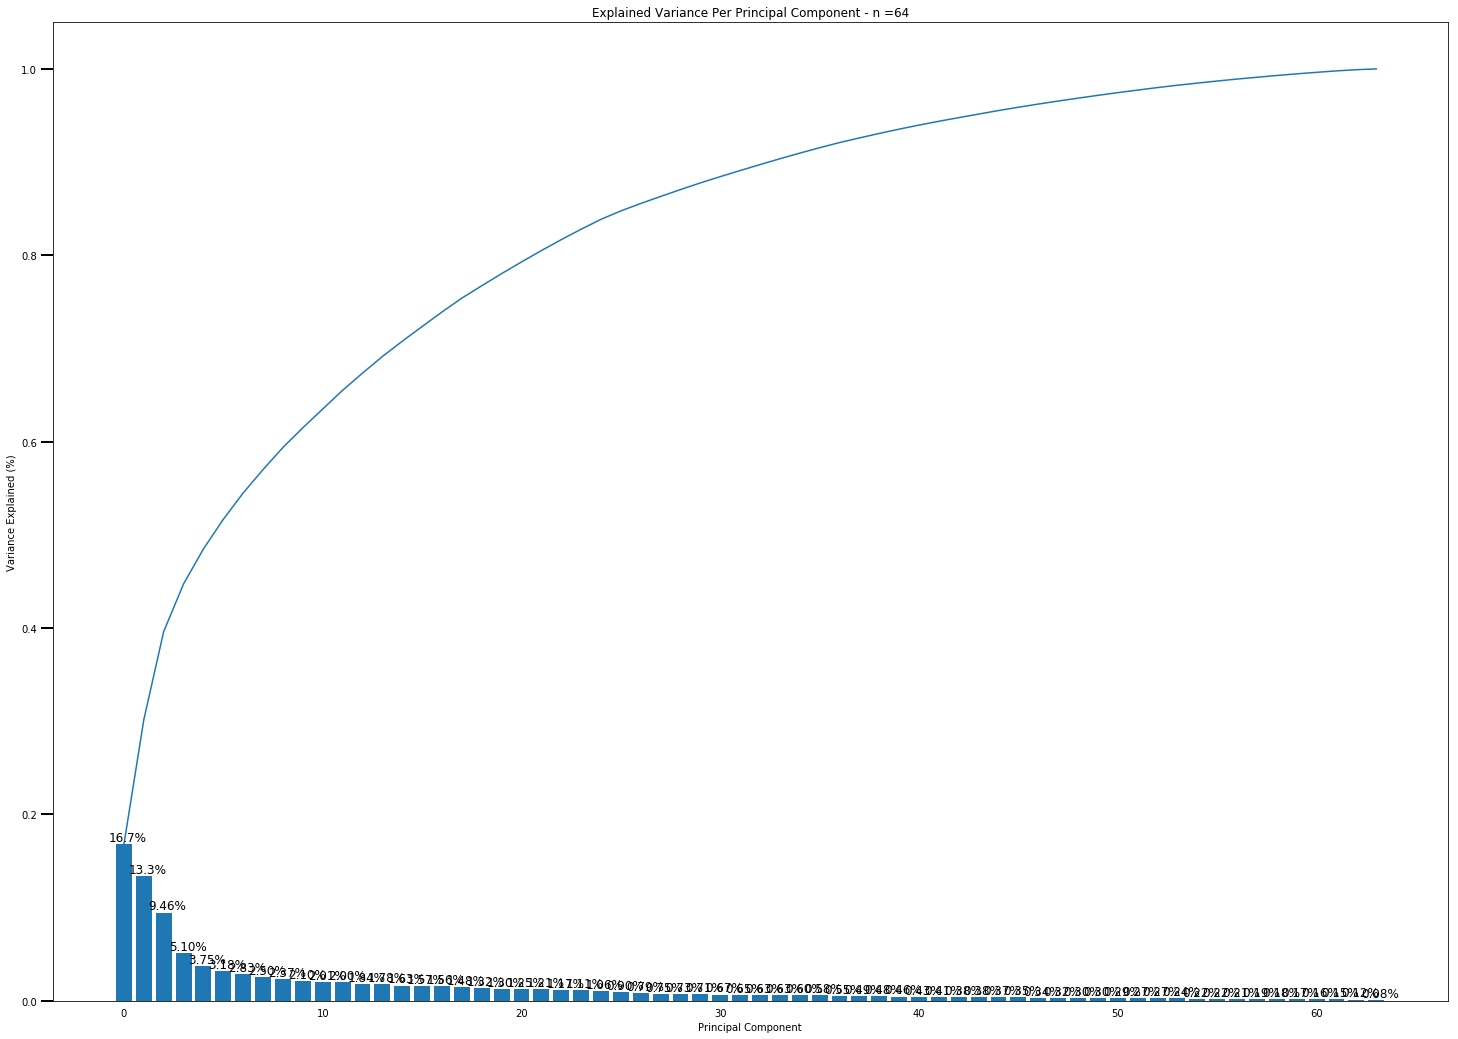

In [147]:
#scree plot
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(25, 18))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title(f'Explained Variance Per Principal Component - n ={num_components}')
    
scree_plot(pca)

In [148]:
n = 35
print (f' Selecting {n} components, we account for the following variance: {np.cumsum(pca.explained_variance_ratio_[:n])[-1]*100}%')



 Selecting 35 components, we account for the following variance: 90.96287293664903%


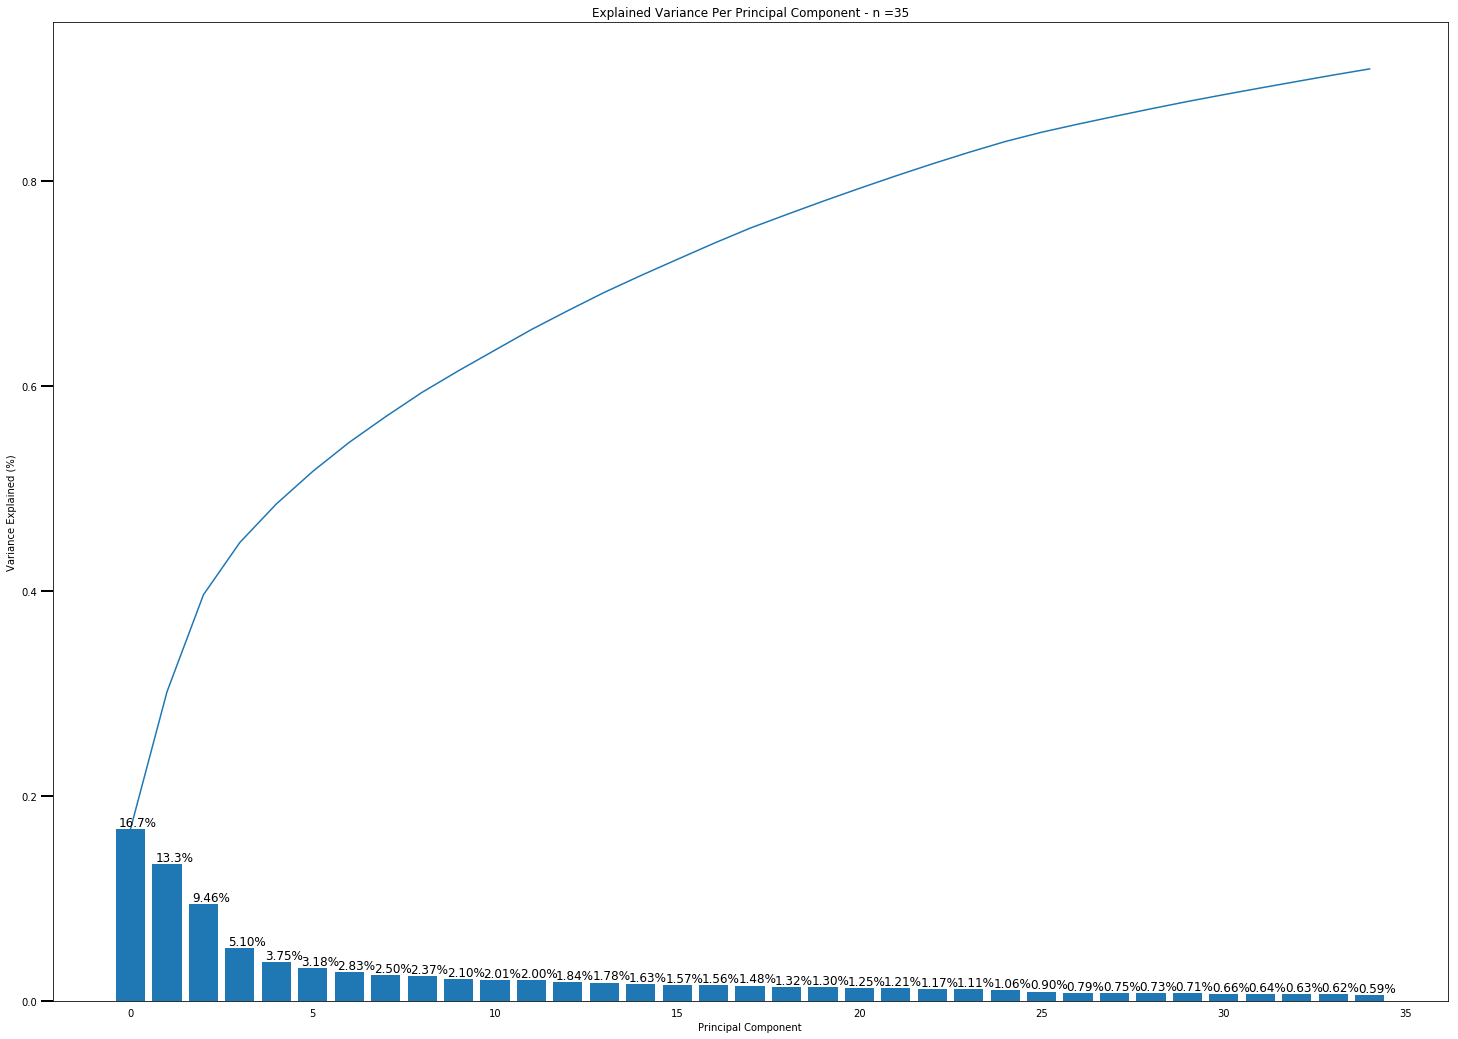

In [149]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 35)
pca = pca.fit(data_trans)

scree_plot(pca)

 Selecting 10 components, we account for the following variance: 61.48416563778495%
*************************************************************************
 Selecting 15 components, we account for the following variance: 70.7650703598898%
*************************************************************************
 Selecting 20 components, we account for the following variance: 78.02542637252972%
*************************************************************************
 Selecting 25 components, we account for the following variance: 83.85294109879698%
*************************************************************************
 Selecting 30 components, we account for the following variance: 87.75649627434771%
*************************************************************************


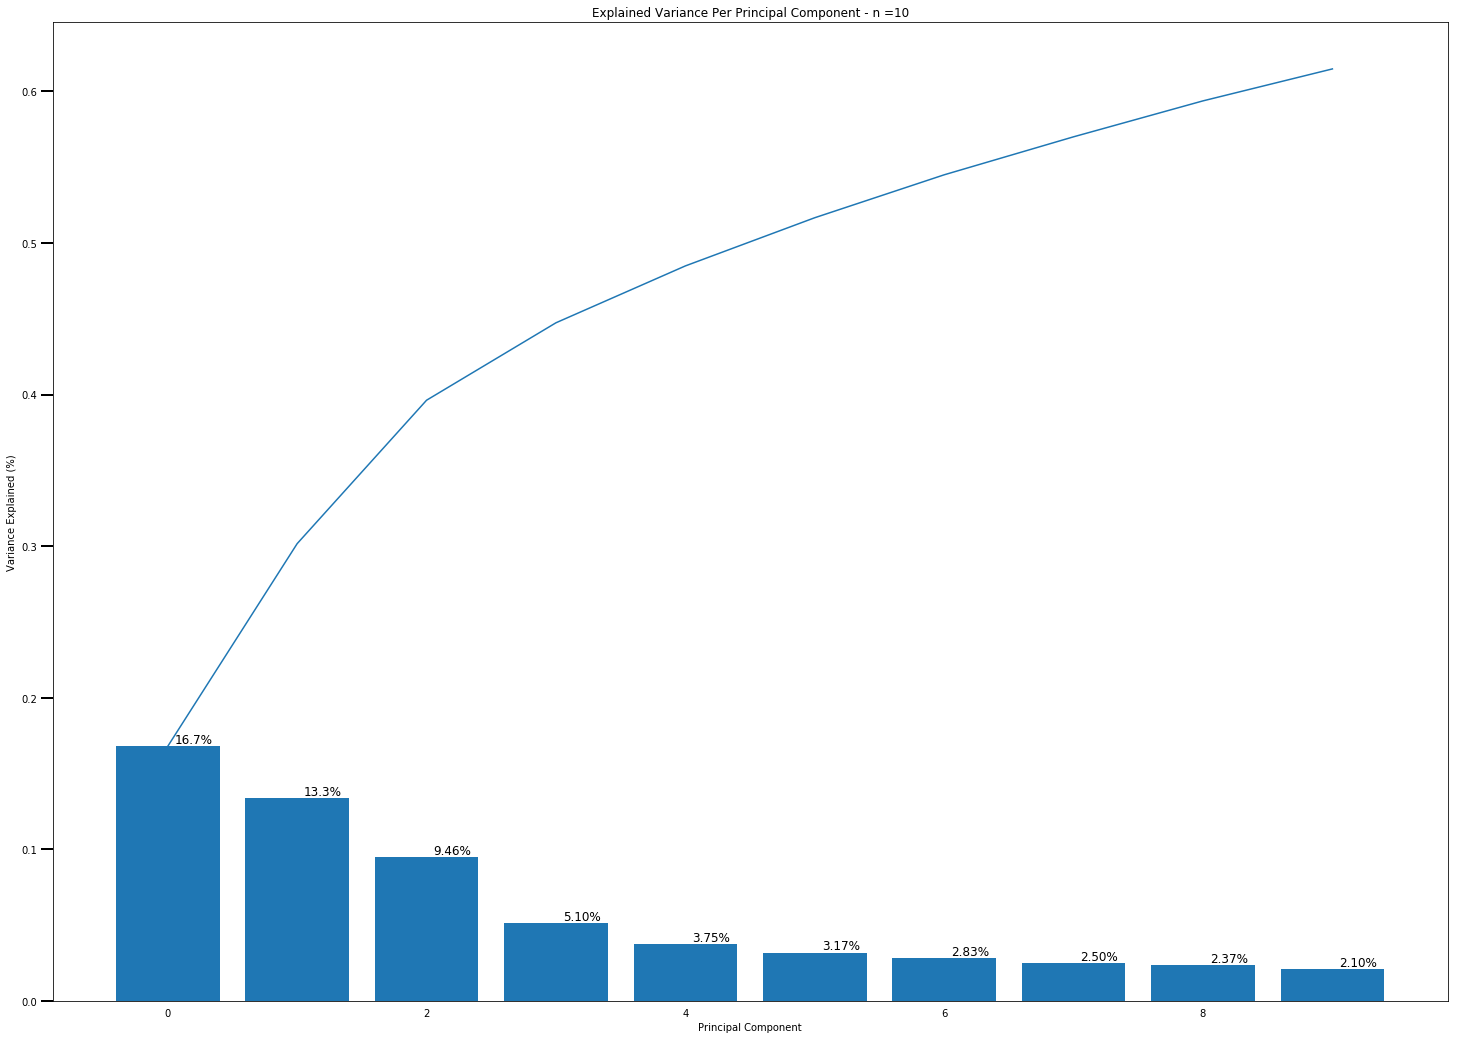

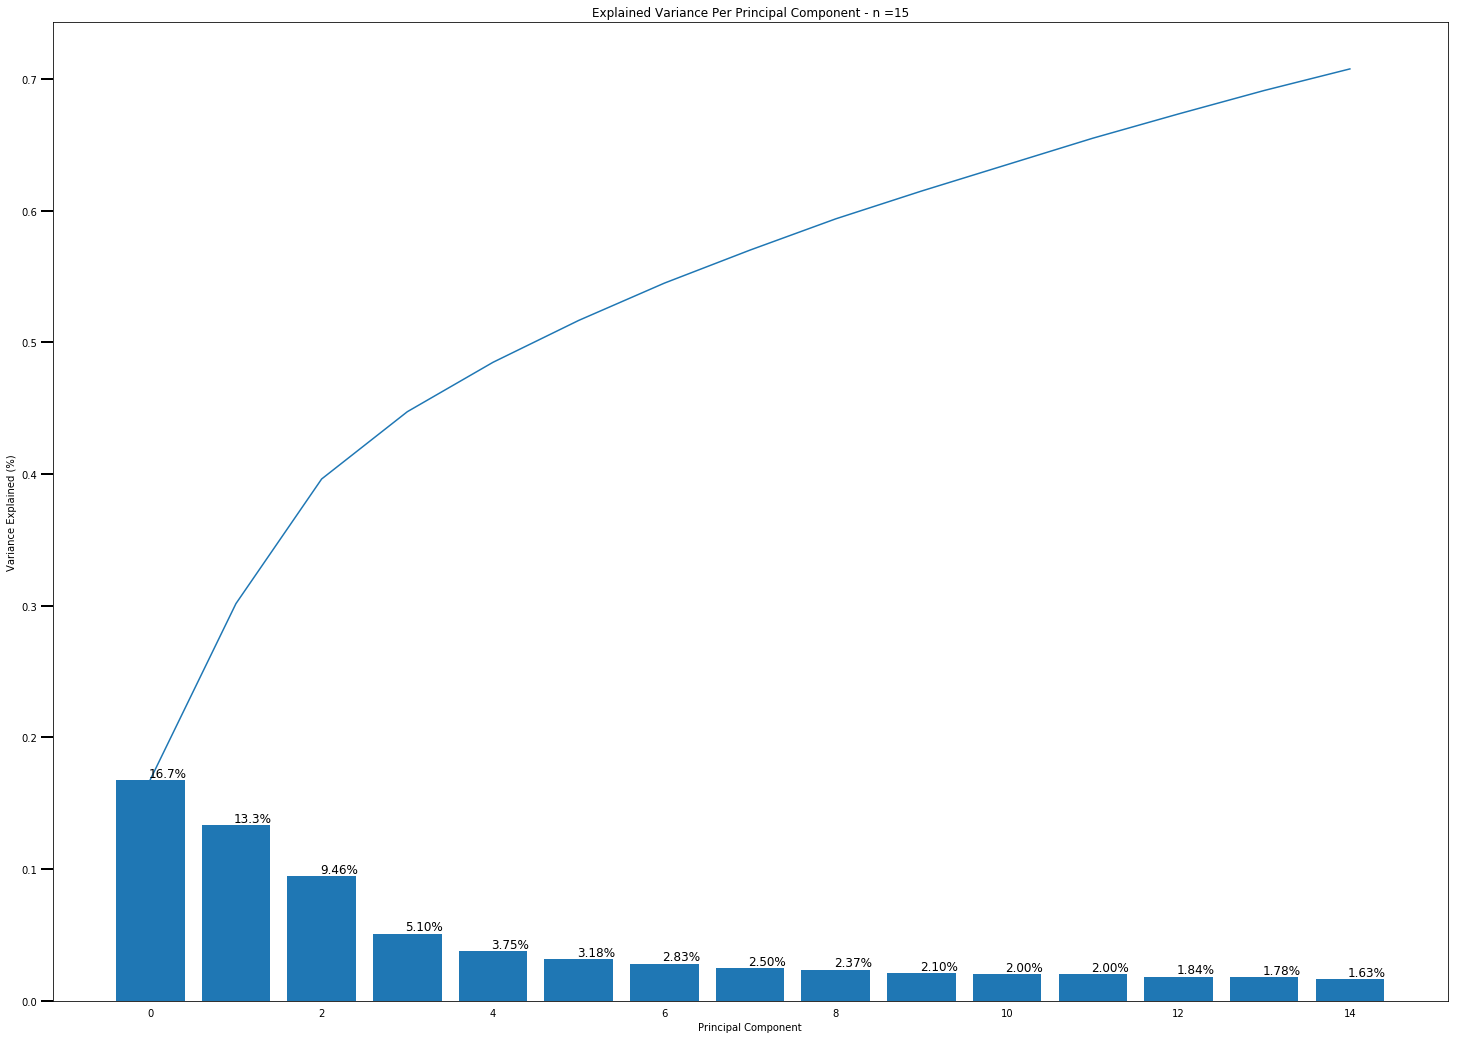

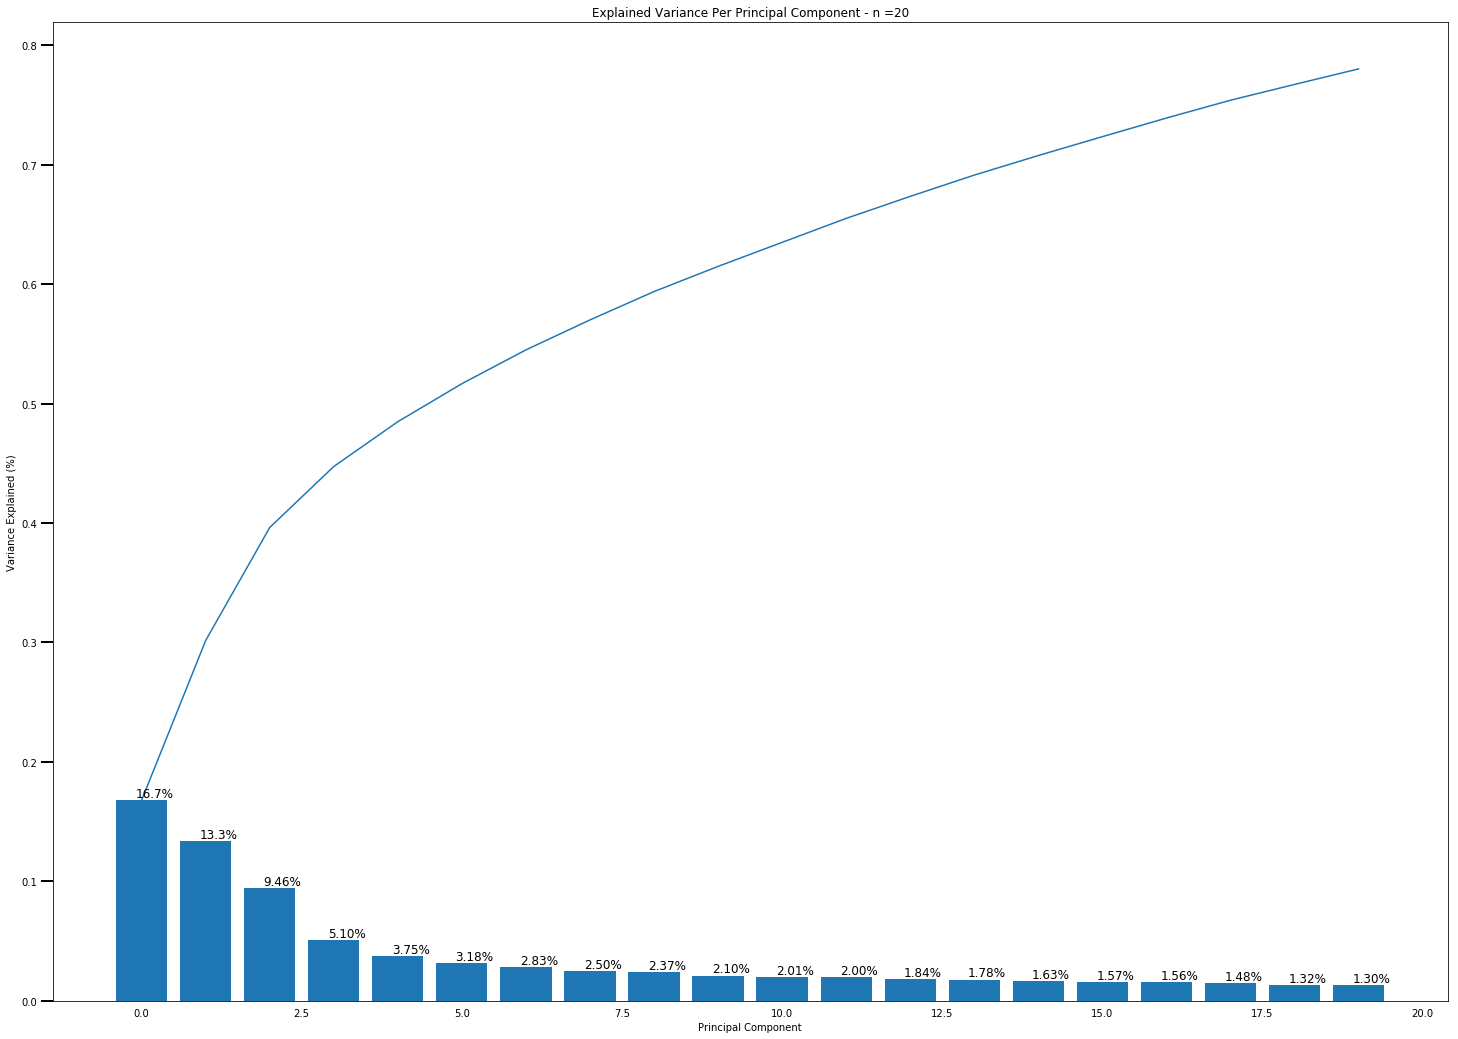

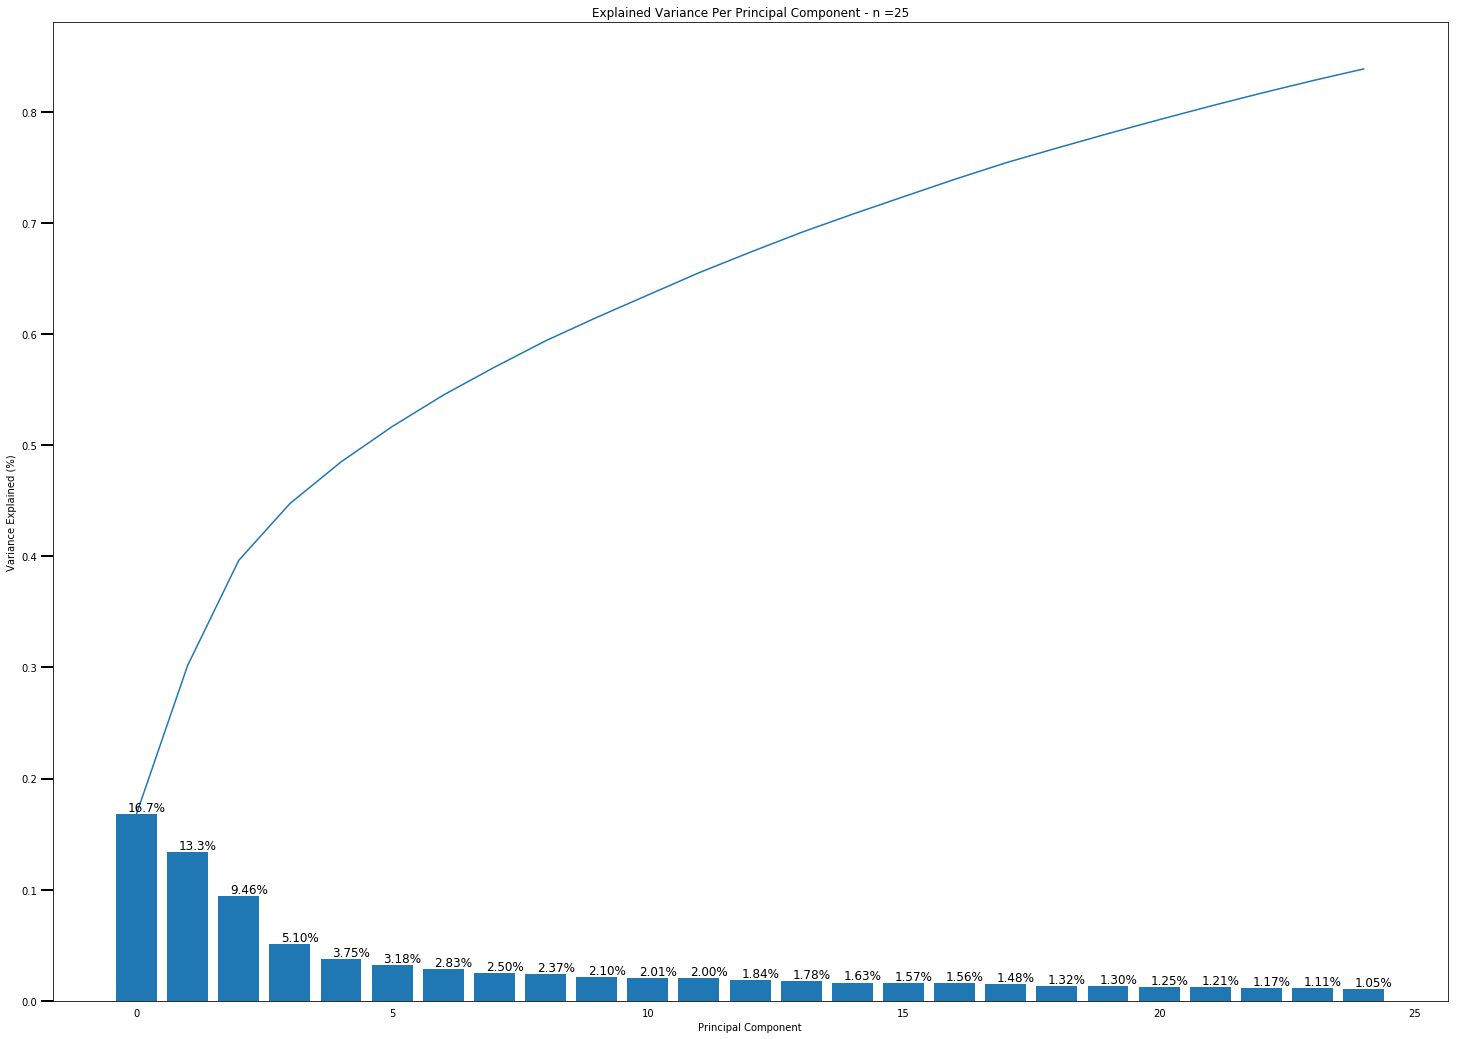

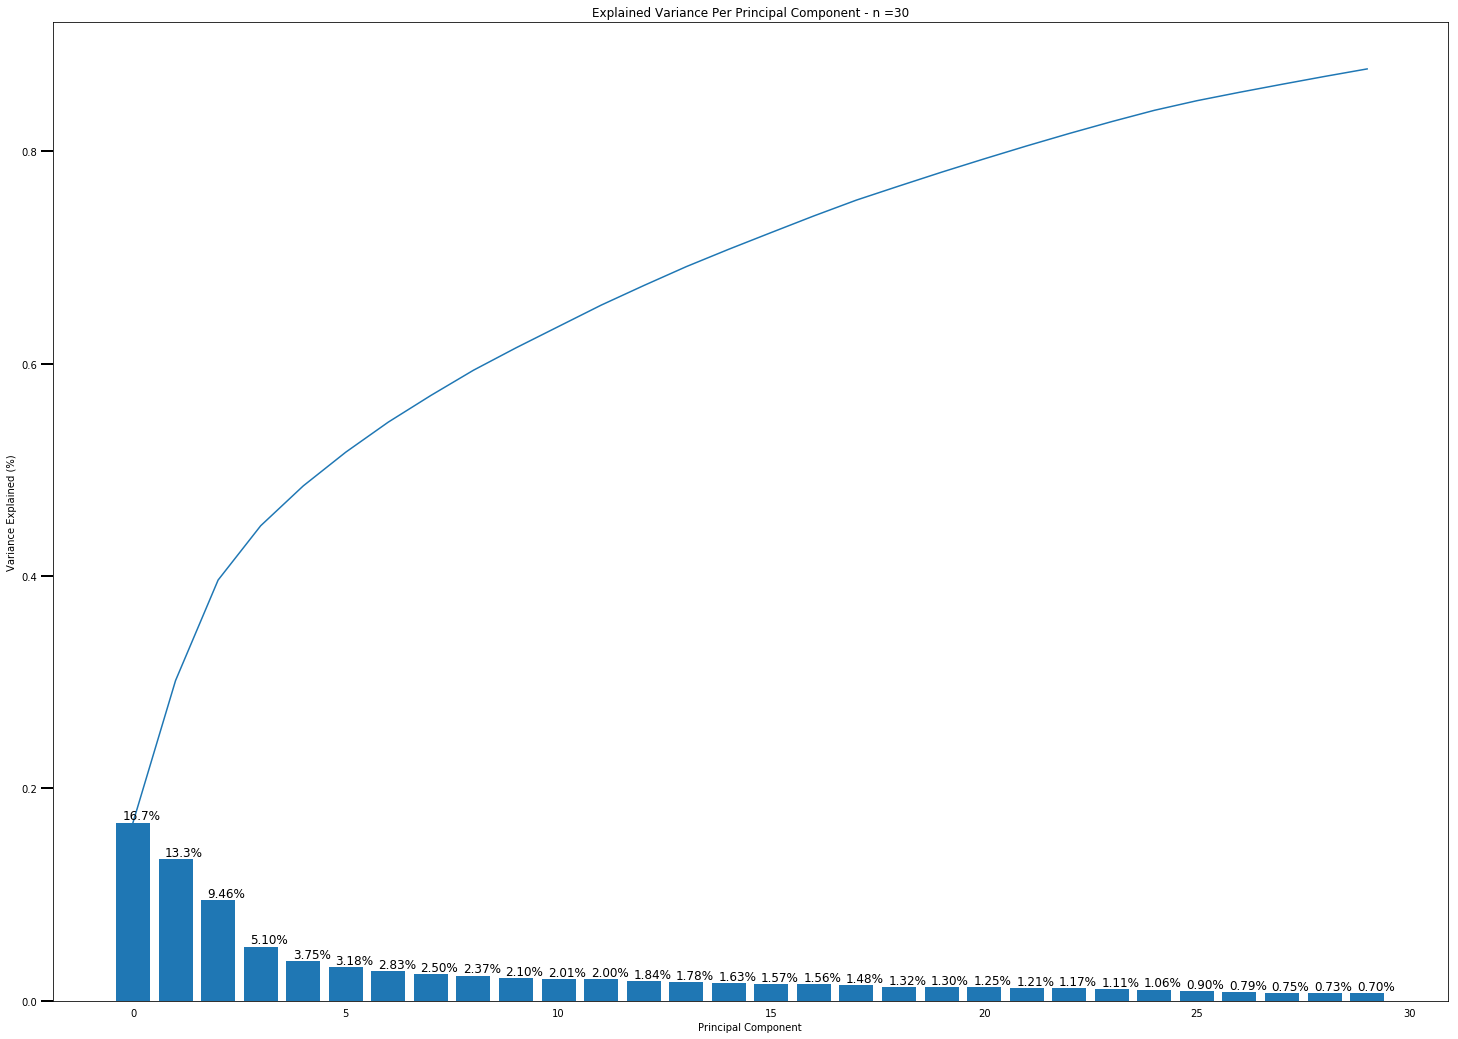

In [150]:
for n in range(10,35,5):
    pca = PCA(n_components = n)
    pca = pca.fit(data_trans)
    scree_plot(pca)
    print (f' Selecting {n} components, we account for the following variance: {np.cumsum(pca.explained_variance_ratio_[:n])[-1]*100}%')
    print ('*************************************************************************')

In [151]:
# final PCA 
pca = PCA(n_components = 20)
pca = pca.fit(data_trans)
data_pca = pca.transform(data_trans)

### Discussion 2.2: Perform Dimensionality Reduction

I applied the dimensionality reduction PCA to the scaled dataset. I did then create two functions, to make a dataframe of the dimensions and then another to plot the scree plot. Both are based on the code form the helper functions seen in the lessons. 
Looking at the first scree plot, one can infer that around 35 components we retain around 90% of the variance of the data. I did then a loop to iterate number of components in the pca from 10 to 35 in steps of 5, to see how much variance is gained. so we have the following results:

    ** n = 10, Variance = 61.47%
    ** n = 15, Variance = 70.76%
    ** n = 20, Variance = 78.03%
    ** n = 25, Variance = 83.85%
    ** n = 30, Variance = 87.75%
    ** n = 35, Variance = 90.96%

Looking at this data, a jump from 10 to 15 components we gain 9% of variance, which is good. Another 5 component increase will alo gain 8% additional variance. Next increase reduces the variance gain, to just a 5%. This is a good "elbow" break to try to simplify the model. 
We could also consider adding 15 more components to gain a 90% in data variance, but that willll make the model more complex. In the end, I chose to stay at 20 components. So, in the end, we reduced the dimensions from 64 to 20. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

,0
PLZ8_ANTG3,0.2231
PLZ8_ANTG4,0.2153
CAMEO_WEALTH,0.2031
HH_EINKOMMEN_SCORE,0.2010
ORTSGR_KLS9,0.1943
EWDICHTE,0.1923
FINANZ_HAUSBAUER,0.1582
FINANZ_SPARER,0.1569
PLZ8_ANTG2,0.1520
KBA05_ANTG4,0.1519


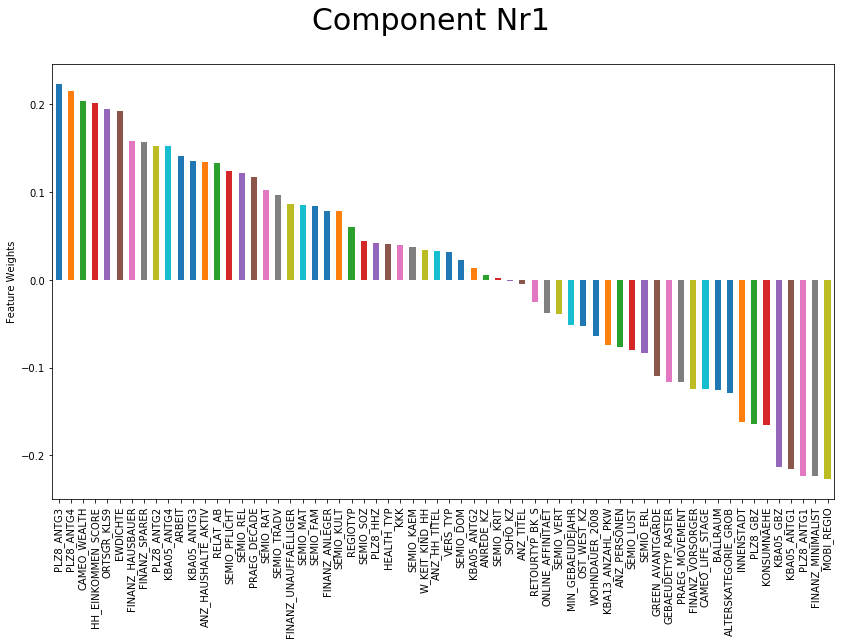

In [152]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#based on helper function from the lesson
# display formula credits to https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.display import display_html
from itertools import chain,cycle

def map_weights(full_dataset, pca,comp_nr):

	weights = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components = weights.iloc[comp_nr - 1, :].sort_values(ascending = False)
	pos = components[components>0].sort_values(ascending = False)
	neg = components [components<0].sort_values(ascending = True)
	pos_10 = pos[:10]
	neg_10 = neg[:10]
	def display_side_by_side(*args,titles=cycle([''])):
	    html_str=''
	    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
	        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
	        html_str+=f'<h2>{title}</h2>'
	        html_str+=df.to_html().replace('table','table style="display:inline"')
	        html_str+='</td></th>'
	    display_html(html_str,raw=True)
	    return
    
	pos_10 = pos_10.to_frame()
	neg_10 = neg_10.to_frame()
	display_side_by_side(pos_10, neg_10, titles = ['10 most Positives','10 most negative'])

    
	fig, ax = plt.subplots(figsize = (14,8))
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	fig.suptitle(f'Component Nr{comp_nr}', fontsize=30)
	return 

map_weights(data_trans,pca,1)


,1
ALTERSKATEGORIE_GROB,0.2534
FINANZ_VORSORGER,0.2266
SEMIO_ERL,0.2263
SEMIO_LUST,0.1779
RETOURTYP_BK_S,0.1625
FINANZ_HAUSBAUER,0.1221
SEMIO_KRIT,0.1171
SEMIO_KAEM,0.1150
W_KEIT_KIND_HH,0.1145
PLZ8_ANTG3,0.1064


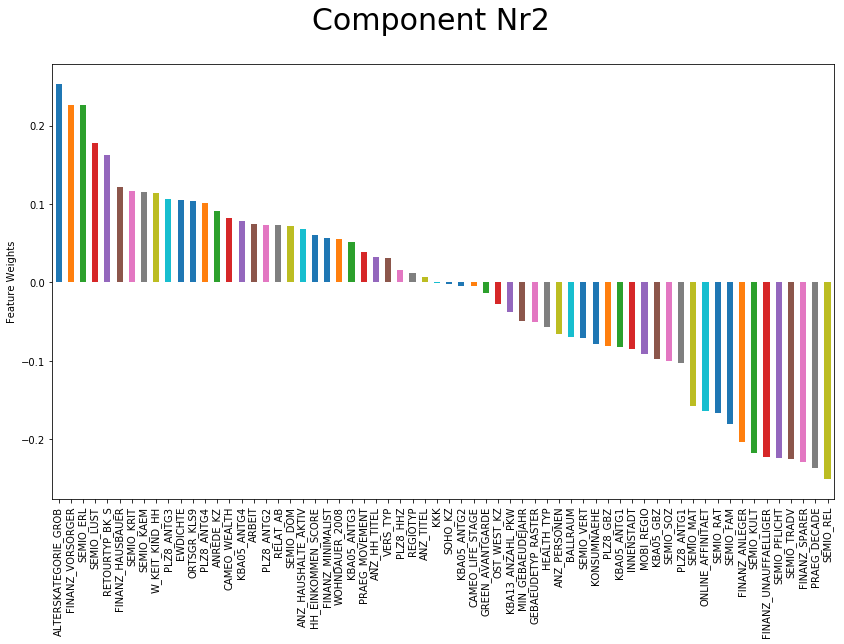

In [153]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(data_trans,pca,2)


,2
SEMIO_VERT,0.3462
SEMIO_SOZ,0.2638
SEMIO_FAM,0.2510
SEMIO_KULT,0.2355
FINANZ_MINIMALIST,0.1544
RETOURTYP_BK_S,0.1079
FINANZ_VORSORGER,0.0986
W_KEIT_KIND_HH,0.0838
ALTERSKATEGORIE_GROB,0.0763
SEMIO_REL,0.0716


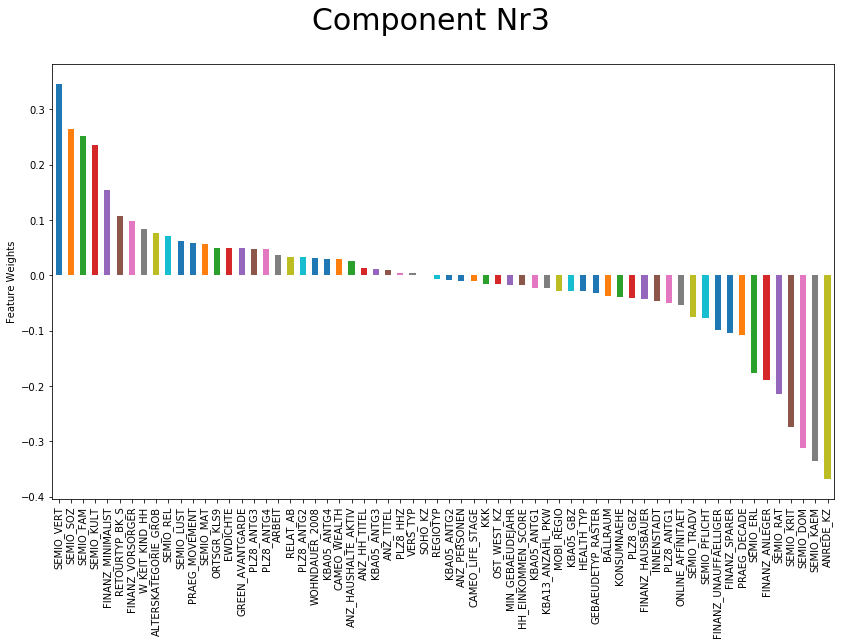

In [154]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(data_trans,pca,3)


### Discussion 2.3: Interpret Principal Components

For the first component, these are the most positive:

* PLZ8_ANTG3 --> Number of 6-10 family houses
* PLZ8_ANTG4 --> Number of 10+ family houses
* CAMEO_WEALTH --> Wealth engineered variable
* HH_EINKOMMEN_SCORE --> Estimated household net income
* ORTSGR_KLS9 --> Size of community

and this the most negative:

* MOBI_REGIO --> Movement patterns
* FINANZ_MINIMALIST --> low financial interest
* PLZ8_ANTG1 --> Number of 1-2 family houses in the PLZ8 region
* KBA05_ANTG1 --> Number of 1-2 family houses in the microcell
* KBA05_GBZ --> Number of buildings in the microcell

#### For the first component it seems to take into account the population density and region/person wealth for the positive values, and for the negatives values too, as they show low financial interest or spare housing.

For the second component, these are the most positive:
* ALTERSKATEGORIE_GROB  -->Estimated age based on given name analysis
* FINANZ_VORSORGER --> be prepared
* SEMIO_ERL --> event-oriented
* SEMIO_LUST --> sensual-minded
* RETOURTYP_BK_S --> Return type of shopper

and this the most negative:

* SEMIO_REL   -->religious
* PRAEG_DECADE  --> engineered variable, forming years!
* FINANZ_SPARER  --> money saver
* SEMIO_TRADV  --> tradional-minded
* SEMIO_PFLICHT  --> dutiful

#### For the second component it takes into account for the positive values the age, financial preparedness and shopper type. It seems the positive values are geared towards older people. The negative values reinforce that thought as young people tend to be less religious, less traditionally minded, less money saver type. So this component takes into account age, generation or generation gap and shopping habits.

For the third component, these are the most positive:
* SEMIO_VERT  --> dreamful
* SEMIO_SOZ  --> socially-minded
* SEMIO_FAM --> family-minded
* SEMIO_KULT --> cultural-minded
* FINANZ_MINIMALIST -->  low financial interest

and this the most negative:

* ANREDE_KZ --> Gender
* SEMIO_KAEM --> : combative attitude
* SEMIO_DOM --> dominant-minded
* SEMIO_KRIT --> critical-minded
* SEMIO_RAT -->  rational

#### For the third component it takes into account for the positive values the mind set, and for negative values the opposite mindset of the positive ones, plus gender. So this component relates to gender and if the person is a "dreamer" or more "ground to earth". The data also may point to a gender tending to being more the dreamer, family, social type and the other gender is the combative, critical and rational one. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [155]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
scores = []
centers = list(range (2,30,3))
for center in centers:
    kmeans= KMeans(n_clusters = center,random_state=42)
    model = kmeans.fit(data_pca)
    scores.append(abs(model.score(data_pca)))
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.
    
scores

[32700780.62248408,
 25990209.151904583,
 22858706.662140589,
 21037003.705055322,
 19971102.74351586,
 18820182.304360457,
 18167510.680995278,
 17457216.175556567,
 16974264.888214521,
 16586752.253489768]

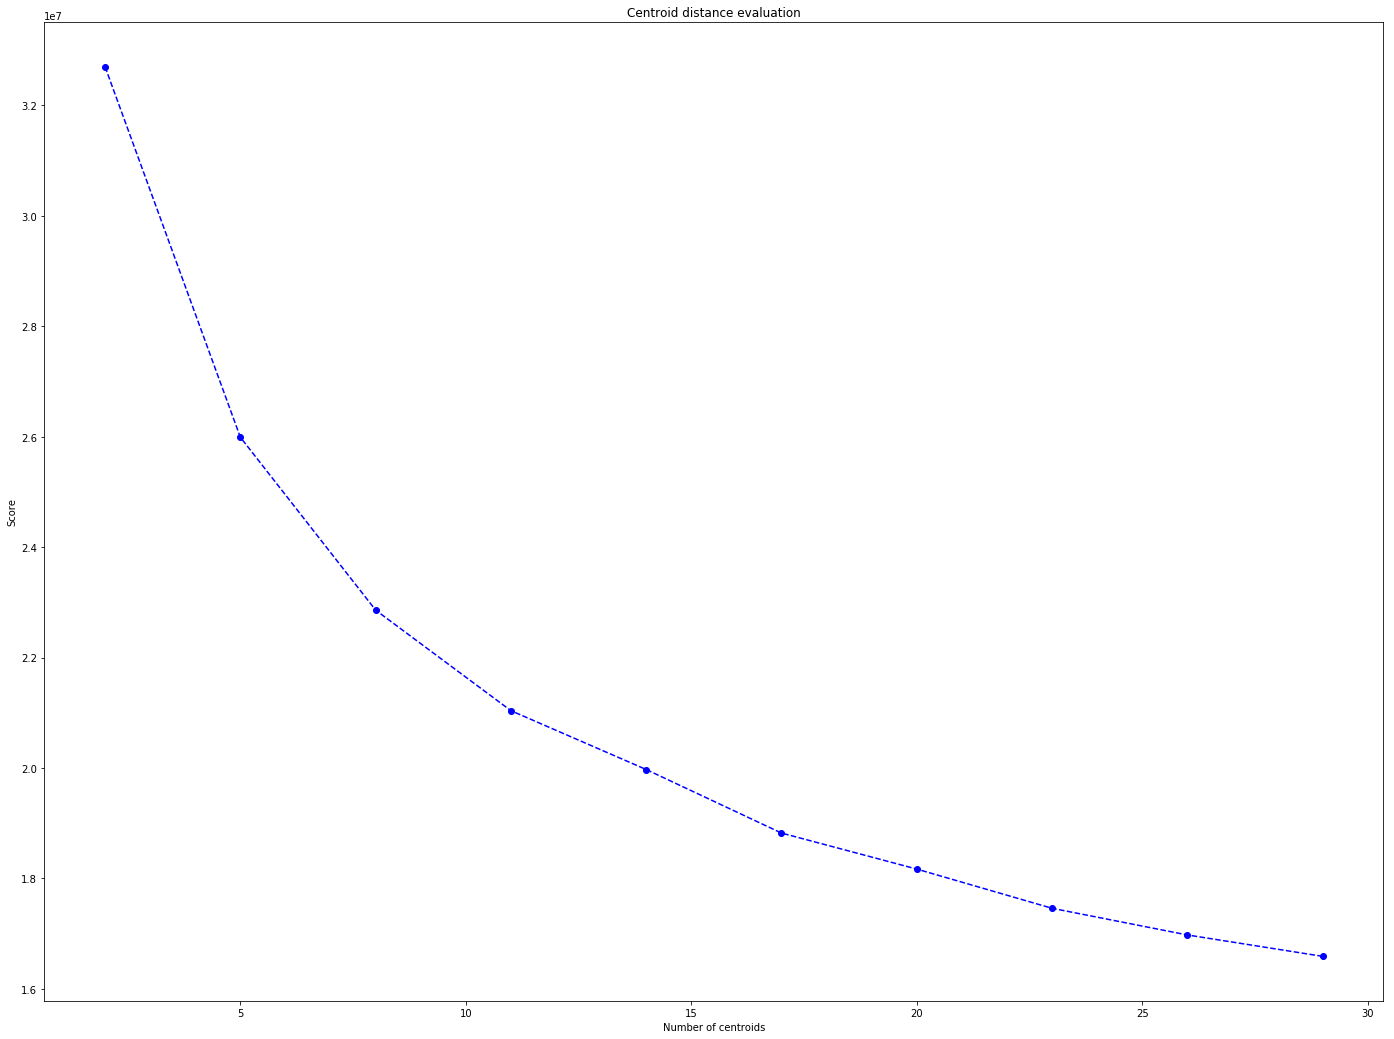

In [6]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from matplotlib.pyplot import figure
# centers =  list(range (2,30,3)) left this code here in case i needed later if the previous cell is executed (and it takes a lot of time!!!)
# scores = [32700780.62248408,  25990209.151904583,  22858706.662140589, 21037003.705055322, 19971102.74351586, 18820182.304360457, 18167510.680995278,  17457216.175556567,  16974264.888214521,  16586752.253489768]

plt.figure(figsize=(24,18));
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of centroids');
plt.ylabel('Score');
plt.title('Centroid distance evaluation');




In [155]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans

k = 12
kmeans = KMeans(n_clusters= k, random_state = 42)
model = kmeans.fit(data_pca)
labels_pred = model.predict(data_pca)
print (f'{k} was selected as the number of centroids, because if one follows the graph of score vs centroids, it seems to reach a break in the elbow about that value')

12 was selected as the number of centroids, because if one follows the graph of score vs centroids, it seems to reach a break in the elbow about that value


### Discussion 3.1: Apply Clustering to General Population

According to the graph, the break in the curve is around 12, where the distance decrease in distance for each additional centroid is not great. I selected this value as the n_clusters for the Kmeans algorithm and then proceeded to create and fit the model. Then the variable "labels_pred" was created to predict the data. 
I tried selecting 18 clusters, but it took aproximately 9 minutes to calculate, so this is another reason I reduced the number of clusters to 12. 

##### I did not run the loop for the clusters again, as it took nearly 2 hours to complete! I did print the score results in order to play with the graph later, generating the needed variables manually. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [156]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [157]:
# how many nans in customer dataset
customers.isnull().sum().sum()

2252274

In [158]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

df_customer, df_cust_NA = clean_data(customers)
df_customer.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEG_DECADE,PRAEG_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFE_STAGE
0,4.0,0,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
2,4.0,1,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0
3,4.0,0,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0


In [159]:
#impute and scale
cust_imp = df_customer.copy()
cust_imp [:] = imp.transform(df_customer)
cust_scale = cust_imp.copy()
cust_scale [:] = scaler.transform(cust_imp)


In [160]:
#pca and kmeans

cust_pca= pca.transform(cust_scale)
cust_pca


array([[-5.99028226,  0.63128402,  4.25724896, ..., -0.2488944 ,
         0.64683492, -0.16531548],
       [-1.88905512,  4.91653218, -0.64458853, ...,  0.13458726,
        -1.15732329, -1.37380791],
       [-4.4697031 ,  0.03244953,  2.70426458, ...,  0.90982366,
        -1.01253214,  0.60808487],
       ..., 
       [-4.66510789,  2.5480864 ,  2.4313498 , ...,  0.70249132,
        -0.34143482,  0.11421567],
       [-1.19398335,  2.63212024, -2.0121054 , ..., -0.39305398,
        -0.36887274, -0.09777426],
       [-3.57450965, -2.99846914,  2.28547871, ...,  0.42867706,
         0.72111144,  0.72712672]])

In [161]:
# predict labels with model
cust_label_pred = model.predict(cust_pca)

In [162]:
np.unique(cust_label_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [163]:
cust_label_pred.shape

(139068,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

    General Population  Customer Population
0             7.243964            32.507838
1             8.314010             0.940547
2             7.428030             0.716196
3            10.871329            10.044007
4             7.632605             0.805361
5            10.607406            18.604568
6            14.522792            17.732332
7             5.918839             4.167026
8             8.041115             1.976731
9             7.995483             1.679035
10            0.431454             2.034257
11           10.992972             8.792102


Text(0,0.5,'Percentage in Cluster')

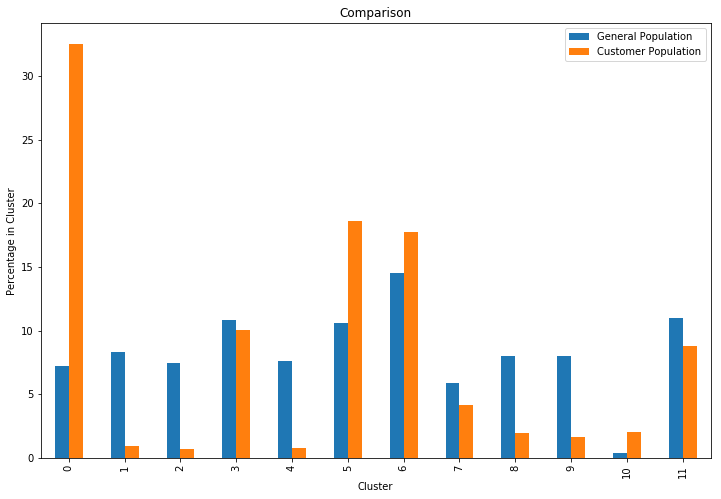

In [165]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
cust_pred = pd.Series(cust_label_pred, name = 'Customer Population').value_counts()
gen_pred = pd.Series(labels_pred,name = 'General Population').value_counts()
cust_pred = cust_pred/cust_pred.sum()*100
gen_pred = gen_pred/gen_pred.sum()*100
cust_avg = cust_pred.to_frame()
gen_avg = gen_pred.to_frame()
comparison = pd.concat([gen_avg, cust_avg], axis = 1)
print(comparison)
comparison.plot(kind="bar", figsize = (12,8))
plt.title("Comparison")
plt.xlabel("Cluster")
plt.ylabel("Percentage in Cluster")


     General Population  Customer Population
-1            12.462453            27.437230
 0             6.341188            23.588588
 1             7.277881             0.682487
 2             6.502315             0.519692
 3             9.516495             7.288210
 4             6.681396             0.584393
 5             9.285463            13.499990
 6            12.712896            12.867072
 7             5.181206             3.023710
 8             7.038995             1.434371
 9             6.999050             1.218354
 10            0.377684             1.476113
 11            9.622978             6.379793


Text(0,0.5,'Percentage in Cluster')

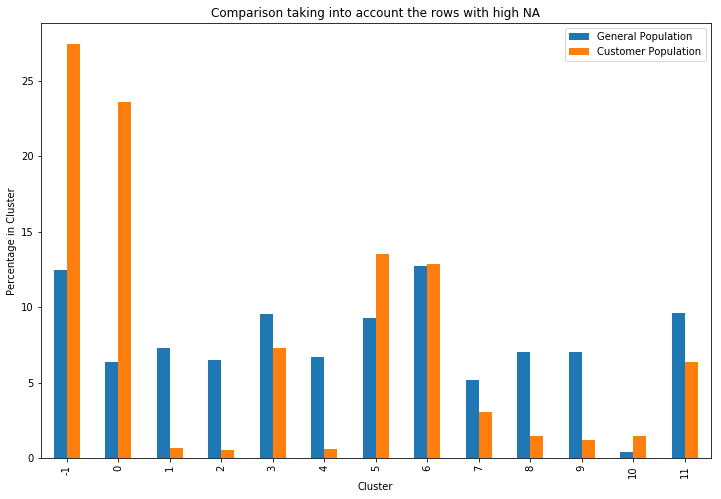

In [166]:
# same code as before, but including the discarded "NA"
cust_pred = pd.Series(cust_label_pred, name = 'Customer Population').value_counts()
gen_pred = pd.Series(labels_pred,name = 'General Population').value_counts()
cust_avg = cust_pred.to_frame()
gen_avg = gen_pred.to_frame()
gen_avg.loc[-1]=[len(df_clean_high)]
cust_avg.loc[-1]=[len(df_cust_NA)]
cust_avg = cust_avg/cust_avg.sum()*100
gen_avg = gen_avg/gen_avg.sum()*100
comparison = pd.concat([gen_avg, cust_avg], axis = 1)
print(comparison)
comparison.plot(kind="bar", figsize = (12,8))
plt.title("Comparison taking into account the rows with high NA")
plt.xlabel("Cluster")
plt.ylabel("Percentage in Cluster")

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.